In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import random
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose #For seasonal decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import date
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.chdir(r"C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project\Datasets")
df = pd.read_csv(r"SIVBQ.csv")

#Exploratory Data Analysis
#Drop data in first line because data there is not needed
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1987-10-26,0.751429,0.843530,0.751429,0.751429,0.740237,5834.0
1,1987-10-27,0.751429,0.843530,0.751429,0.751429,0.740237,23337.0
3,1987-10-29,0.751429,0.843530,0.751429,0.751429,0.740237,14586.0
4,1987-10-30,0.751429,0.843530,0.751429,0.751429,0.740237,21879.0
5,1987-11-02,0.722997,0.772647,0.722997,0.722997,0.712229,10210.0
...,...,...,...,...,...,...,...
9016,2023-08-08,0.130000,0.140000,0.080000,0.100000,0.100000,135155.0
9017,2023-08-09,0.100000,0.200000,0.100000,0.100000,0.100000,96415.0
9018,2023-08-10,0.080000,0.170000,0.080000,0.150000,0.150000,41184.0
9019,2023-08-11,0.150000,0.240000,0.150000,0.200000,0.200000,145275.0


In [5]:
#Changing data types
df['Date'] = pd.to_datetime(df['Date'])

#Checking for missing value and percentage of missing values
df_notna = pd.DataFrame(df.notna().sum()).rename(columns={0:'notna'}).reset_index()
df_isna = pd.DataFrame(df.isna().sum()).rename(columns={0:'isna'}).reset_index()
df_isna_perc = df_notna.merge(df_isna, on='index', how='inner')
df_isna_perc['isna_percentage'] = df_isna_perc['isna']/(df_isna_perc['isna']+df_isna_perc['notna'])*100
df_isna_perc.sort_values('isna_percentage',ascending=False).head()
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,1987-10-26,0.751429,0.843530,0.751429,0.751429,0.740237,5834.0
1,1987-10-27,0.751429,0.843530,0.751429,0.751429,0.740237,23337.0
3,1987-10-29,0.751429,0.843530,0.751429,0.751429,0.740237,14586.0
4,1987-10-30,0.751429,0.843530,0.751429,0.751429,0.740237,21879.0
5,1987-11-02,0.722997,0.772647,0.722997,0.722997,0.712229,10210.0
...,...,...,...,...,...,...,...
9016,2023-08-08,0.130000,0.140000,0.080000,0.100000,0.100000,135155.0
9017,2023-08-09,0.100000,0.200000,0.100000,0.100000,0.100000,96415.0
9018,2023-08-10,0.080000,0.170000,0.080000,0.150000,0.150000,41184.0
9019,2023-08-11,0.150000,0.240000,0.150000,0.200000,0.200000,145275.0


In [6]:
### Initiate LSTM Model
class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       --Attributes--
           hidden_dim: int 
               The number of nodes in each layer
           layer_dim: int
               The number of layers in the network
           lstm: nn.LSTM
               The LSTM model constructed with the input parameters.
           fc: nn.Linear
               The fully connected layer to convert the final state of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a LSTM instance.

        --Arguments--
            input_dim: int
                The number of nodes in the input layer
            hidden_dim: int
                The number of nodes in each layer
            layer_dim: int
                The number of layers in the network
            output_dim: int
                The number of nodes in the output layer
            dropout_prob: float
                The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        #Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        #LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        --Arguments--
            x: torch.Tensor 
                The input tensor of the shape (batch size, sequence length, input_dim)

        --Returns--
            out: torch.Tensor 
                The output tensor of the shape (batch size, output_dim)

        """
        #Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        #Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        #We need to detach as we are doing truncated backpropagation through time (BPTT)
        #If we don't, we'll backprop all the way to the start even after going through another batch
        #Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        #Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size) so that it can fit into the fully
        #connected layer
        out = out[:, -1, :]

        #Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

#Making predictions
class Optimization:
    """
    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    --Attributes--
        model: 
            Model class created for the type of RNN
        loss_fn: torch.nn.modules.Loss
            Loss function to calculate the losses
        optimizer: torch.optim.Optimizer 
            Optimizer function to optimize the loss function
        train_losses: list[float]
            The loss values from the training
        val_losses: list[float]
            The loss values from the validation
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """
        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        --Arguments--
            x: torch.Tensor
                Tensor for features to train one step
            y: torch.Tensor
                Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """
        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. Finally, it saves the model in a designated file path.

        --Arguments--
            train_loader: torch.utils.data.DataLoader
                DataLoader that stores training data
            val_loader: torch.utils.data.DataLoader
                DataLoader that stores validation data
            batch_size: int
                Batch size for mini-batch training
            n_epochs: int 
                Number of epochs, i.e., train steps, to train
            n_features: int
                Number of feature columns

        """
        model_path = f'model_lstm'
        
        for epoch in range(1, n_epochs + 1):
            # mini-batch training iteration of training datasets
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
                # update training loss value
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            with torch.no_grad():
                # mini-batch training iteration of validation datasets
                batch_val_losses = []
                validation = []
                validation_values = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                    #
                    validation.append(yhat.to(device).detach().numpy())
                    validation_values.append(y_val.to(device).detach().numpy())
                # update validation loss value
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
            
            # print loss value per epoch period
            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
        return validation, validation_values

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model
            values: list[float]
                The actual values in the test set.

        """
        # mini-batch testing to evaluate data from test dataset
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                # save model prediction result to list
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def predict(self, future_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the predicting future dataset, batch size for mini-batch testing,
        and number of features as inputs. 

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model

        """
        # mini-batch testing to predict data from future dataset
        with torch.no_grad():
            predictions = []
            for x_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                self.model.eval()
                yhat = self.model(x_test)
                # save model prediction result to list
                predictions.append(yhat.to(device).detach().numpy())

        return predictions
    
    def plot_losses(self):
        """
        The method plots the calculated loss values for training and validation
        """
        plt.figure(figsize=[8, 5])
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"{device}" " is available.")

cpu is available.


In [7]:
df = df.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis = 1)
df

,Date,Open
0,1987-10-26,0.751429
1,1987-10-27,0.751429
3,1987-10-29,0.751429
4,1987-10-30,0.751429
5,1987-11-02,0.722997
...,...,...
9016,2023-08-08,0.130000
9017,2023-08-09,0.100000
9018,2023-08-10,0.080000
9019,2023-08-11,0.150000


Total Stock price: $321.96


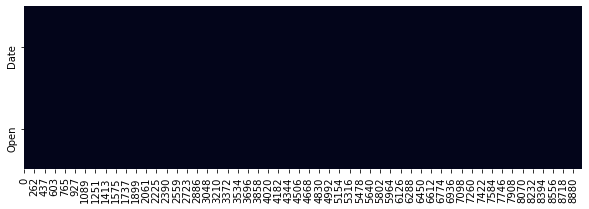

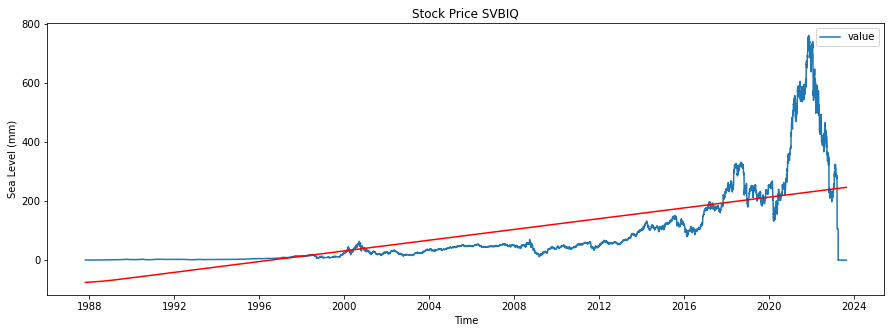

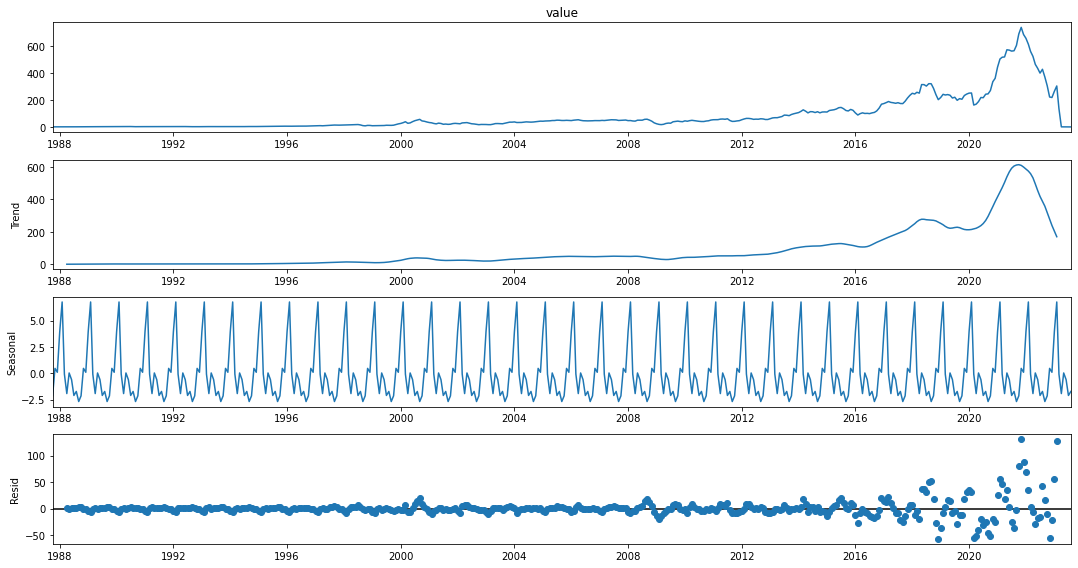

Total Stock price: $318.41


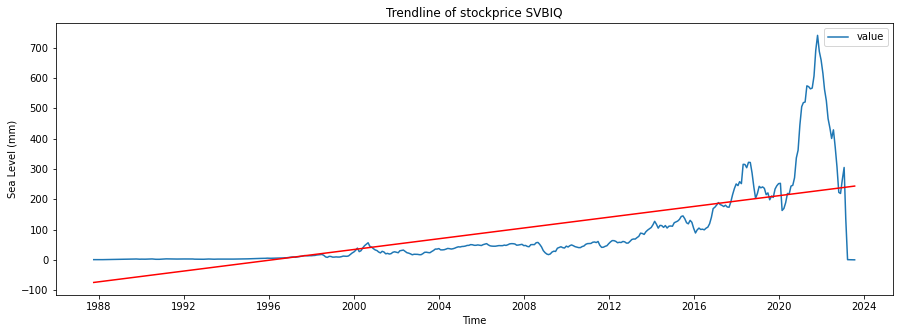

In [22]:
#Checking missing value location in the data
plt.figure(figsize=(10, 3))
_ = sns.heatmap(df.isnull().T, cbar=False) #Transpose the data so easier to see

#Visualising the data
def plot_dataset_trendline(df, title, label='value'):
    plt.figure(figsize=(15, 5))
    #Plot dataset
    sns.lineplot(x=df.index, y=df.value, label=label)

    #Plot trendline (Have to be clean from missing data)
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=1)  
    p = np.poly1d(z)
    plt.plot(df.index, p(x), c="r", ls='-')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sea Level (mm)')
    print(f'Total Stock price: ${round(p(len(df)) - p(0), 2)}')

#Make a new dataset for plotting --> After dropping values
df_plot = df.dropna()
df_plot['year'] = df_plot['Date'].dt.year
df_plot = df_plot.set_index(['Date'])
df_plot = df_plot.rename(columns={'Open': 'value'})
df_plot

#Plot all of the dataset from 1921 - 2014
plot_dataset_trendline(df_plot, 'Stock Price SVBIQ')
#Total Sea Level Rise = 297.52mm

#Seasonal Decomposition
df_plot2 = df_plot.resample('M').mean()
df_plot2.reset_index(inplace= True)
df_plot2['time'] = df_plot2['Date'].dt.to_period('M')
df_plot2 = df_plot2.set_index('time')
# df_plot2.interpolate(inplace = True)
df_plot2.index = df_plot2.index.to_timestamp()
df_plot2.head()

plt.rc("figure", figsize=(15,8))
result = seasonal_decompose(df_plot2['value'], model= 'additive')
result.plot()
plt.show()

# #Choosing the Data
# #Subsetting data from 1995 until 2014
# df['year'] = df['time'].dt.year
# df_m95 = df[df['year'] > 1994]

df_m95 = df_plot2

df_m95 = df_m95.reset_index()
df_m95.drop(columns=['year'], inplace=True)
df_m95

#Make a copy as a safety measure for later process
df_try = df_m95.copy()
df_try.tail(2)

df_try = df_try.set_index(['time'])
df_try = df_try.rename(columns={'Open': 'value'})
df_try

#Plot the dataset that we're gonna use
plot_dataset_trendline(df_try, title='Trendline of stockprice SVBIQ')
#Total Sea Level rise = 74.2mm

#Generate day, month, and year feature
df_features = (df_try.assign(day = df_try.index.day).assign(month = df_try.index.month).assign(year = df_try.index.year))
df_features
df_features = df_features.drop(['Date'], axis = 1)

def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1) #.drop(columns=col)
    return df

# #One-hot encoding for categorical value from datetime feature
# df_features = onehot_encode_pd(df_features, ['day', 'month', 'week_of_year', 'year'])
# df_features['year_2015'], df_features['year_2016'] = 0, 0 #For predicting future event purpose
# df_features

def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

# df_features = generate_cyclical_features(df_features, 'day', 31, 1)
# df_features = generate_cyclical_features(df_features, 'month', 12, 1)
# df_features = generate_cyclical_features(df_features, 'week_of_year', 52, 0)

# df_features.tail(3)

# df_features.columns

#Function for splitting target dan predictor variable
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

#Function for splitting data to train, test, and validation data
def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

random.seed(3407)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features, 'value', 0.3)

#Function to pick scaler 
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

scaler = get_scaler('minmax')

#Fit and apply scaler to predictor variable
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

#Fit and apply scaler to target variable
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

batch_size = 32

#Convert data shape to tensor (multi-dimensional matrix containing elements of a single data type)
train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

#Wrapping the tensors above as Dataset
train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

#Convert data to Pytorch DataLoader (collating data samples into batches)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

#LSTM config
input_dim = len(X_train.columns)
output_dim = 1 
hidden_dim = 64 
layer_dim = 1000
batch_size = batch_size
dropout = 0.05
#Training and evaluate config
n_epochs = 30
#Weight optimization config
learning_rate = 1e-3
weight_decay = 1e-6

#Bundle config in dictionary
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

#Model Optimisation
model = LSTMModel(**model_params)

In [9]:
model

LSTMModel(
  (lstm): LSTM(3, 64, num_layers=1000, batch_first=True, dropout=0.05)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

[1/100] Training loss: 0.0376	 Validation loss: 0.4306
[2/100] Training loss: 0.0368	 Validation loss: 0.4069
[3/100] Training loss: 0.0376	 Validation loss: 0.4140
[4/100] Training loss: 0.0370	 Validation loss: 0.4220
[5/100] Training loss: 0.0365	 Validation loss: 0.4241
[6/100] Training loss: 0.0362	 Validation loss: 0.4221
[7/100] Training loss: 0.0360	 Validation loss: 0.4192
[8/100] Training loss: 0.0361	 Validation loss: 0.4177
[9/100] Training loss: 0.0361	 Validation loss: 0.4179
[10/100] Training loss: 0.0362	 Validation loss: 0.4188
[20/100] Training loss: 0.0360	 Validation loss: 0.4193
[30/100] Training loss: 0.0359	 Validation loss: 0.4190
[40/100] Training loss: 0.0359	 Validation loss: 0.4191
[50/100] Training loss: 0.0359	 Validation loss: 0.4191
[60/100] Training loss: 0.0359	 Validation loss: 0.4191
[70/100] Training loss: 0.0358	 Validation loss: 0.4192
[80/100] Training loss: 0.0358	 Validation loss: 0.4189
[90/100] Training loss: 0.0358	 Validation loss: 0.4192
[

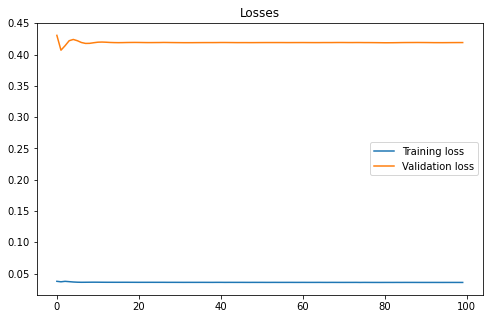

In [44]:
#Mean reduction for LSTM

#LSTM config
input_dim = len(X_train.columns)
output_dim = 1 
hidden_dim = 1000
layer_dim = 100
batch_size = batch_size
dropout = 0.05
#Training and evaluate config
n_epochs = 100
#Weight optimization config
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

#Model Optimisation
model = LSTMModel(**model_params)

#Setting criterion to calculate loss gradient
loss_fn = nn.MSELoss(reduction="mean")
#Setting model optimizer (process of adjusting model parameters to reduce model error in each training step)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Training the model
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
validation, validation_values = opt.train(
    train_loader, 
    val_loader, 
    batch_size=batch_size, 
    n_epochs=n_epochs, 
    n_features=input_dim,
)
opt.plot_losses()

#Evaluating model based on model from training dataset
predictions, values = opt.evaluate(
    test_loader,
    batch_size=batch_size,
    n_features=input_dim
)


[1/100] Training loss: 1.1309	 Validation loss: 12.7264
[2/100] Training loss: 1.2690	 Validation loss: 13.2133
[3/100] Training loss: 1.2075	 Validation loss: 13.6715
[4/100] Training loss: 1.1716	 Validation loss: 13.6748
[5/100] Training loss: 1.1534	 Validation loss: 13.4823
[6/100] Training loss: 1.1549	 Validation loss: 13.3527
[7/100] Training loss: 1.1583	 Validation loss: 13.3290
[8/100] Training loss: 1.1615	 Validation loss: 13.3758
[9/100] Training loss: 1.1628	 Validation loss: 13.4330
[10/100] Training loss: 1.1604	 Validation loss: 13.4637
[20/100] Training loss: 1.1529	 Validation loss: 13.4212
[30/100] Training loss: 1.1537	 Validation loss: 13.4128
[40/100] Training loss: 1.1491	 Validation loss: 13.4067
[50/100] Training loss: 1.1496	 Validation loss: 13.4092
[60/100] Training loss: 1.1497	 Validation loss: 13.4066
[70/100] Training loss: 1.1495	 Validation loss: 13.4129
[80/100] Training loss: 1.1479	 Validation loss: 13.4123
[90/100] Training loss: 1.1479	 Validati

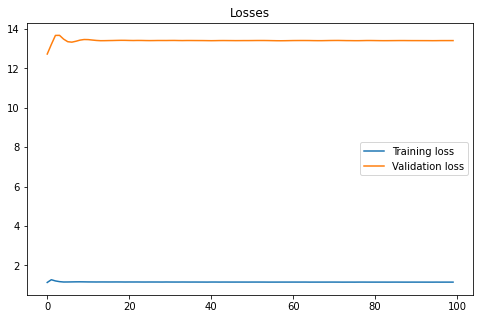

In [9]:
#SUM Reduction for LSTM

#LSTM config
input_dim = len(X_train.columns)
output_dim = 1 
hidden_dim = 1000
layer_dim = 100
batch_size = batch_size
dropout = 0.05
#Training and evaluate config
n_epochs = 100
#Weight optimization config
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

#Model Optimisation
summodel = LSTMModel(**model_params)

#Setting criterion to calculate loss gradient
loss_fn = nn.MSELoss(reduction="sum")
#Setting model optimizer (process of adjusting model parameters to reduce model error in each training step)
optimizer = optim.AdamW(summodel.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Training the model
opt = Optimization(model=summodel, loss_fn=loss_fn, optimizer=optimizer)
validation, validation_values = opt.train(
    train_loader, 
    val_loader, 
    batch_size=batch_size, 
    n_epochs=n_epochs, 
    n_features=input_dim,
)
opt.plot_losses()

#Evaluating model based on model from training dataset
predictions, values = opt.evaluate(
    test_loader,
    batch_size=batch_size,
    n_features=input_dim
)


In [50]:
import pickle

with open('model.pkl', 'wb') as handle:
    pickle.dump(opt, handle)

# import pickle

# with open('summodel', 'wb') as handle:
#     pickle.dump(summodel, handle)

In [ ]:
# inverse the scale from model result
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

# change format of multi-dimensional tensors to one-dimensional vectors (flatten)
def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

In [ ]:
df_val = format_predictions(validation, validation_values, X_val, scaler)
df_result = format_predictions(predictions, values, X_test, scaler)
df_result.head()

,value,prediction
time,,
2012-11-01,55.280476,7.958606
2012-12-01,55.435997,7.958606
2013-01-01,60.973812,7.958606
2013-02-01,67.092110,7.958606
2013-03-01,68.733505,7.958606


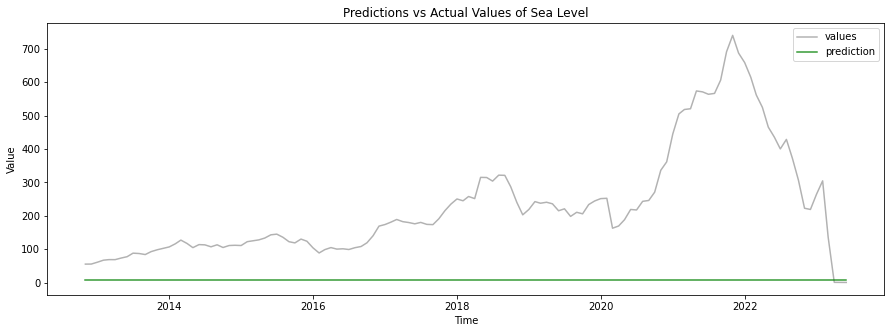

In [ ]:
def plot_predictions(df_result):
    plt.figure(figsize=(15,5))
    value = sns.lineplot(x = df_result.index, y=df_result.value, color='k', alpha = 0.3, label = 'values')
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='g', alpha = 0.8, label = 'prediction')
    
    plt.title("Predictions vs Actual Values of Sea Level")
    plt.xlabel('Time')
    plt.ylabel('Value') 
    
plot_predictions(df_result)

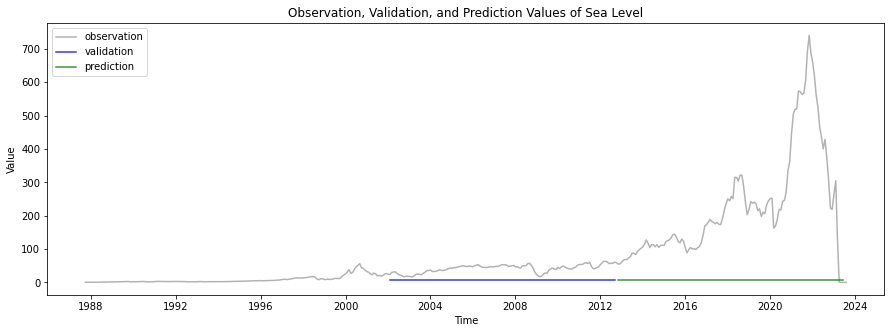

In [ ]:
def plot_all(df_result, df_train, df_val):
    plt.figure(figsize=(15,5))
    observation = sns.lineplot(x = df_train.index, y=df_train.value, color='k', alpha = 0.3, label = 'observation')
    validation = sns.lineplot(x = df_val.index, y=df_val.prediction, color='b', alpha = 0.8, label = 'validation')
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='g', alpha = 0.8, label = 'prediction')
    
    plt.title("Observation, Validation, and Prediction Values of Sea Level")
    plt.xlabel('Time')
    plt.ylabel('Value') 
    
plot_all(df_result, df_features, df_val)

In [1]:
import pickle
import numpy as np
import pandas as pd


In [53]:
# timeInput = input("Please enter a future time to predict: ")

model = pickle.load(open('model.pkl', 'rb'))
# price_pred = svbPrice.predict(timeInput)


In [54]:
def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1) #.drop(columns=col)
    return df
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
            }
    return df.assign(**kwargs).drop(columns=[col_name])
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y
def give_year_name(df, start, end, name):
    i = start
    while i <= end:
        df[f'{name}_{i}'] = 0
        i += 1
    return df
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df
def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


def evaluate(self, test_loader, batch_size=1, n_features=1):
    """
    The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
    and number of features as inputs. Similar to the model validation, it iteratively
    predicts the target values and calculates losses. Then, it returns two lists that
    hold the predictions and the actual values.

    Note:
        This method assumes that the prediction from the previous step is available at
        the time of the prediction, and only does one-step prediction into the future.

    --Arguments--
        test_loader: torch.utils.data.DataLoader 
            DataLoader that stores test data
        batch_size: int
            Batch size for mini-batch training
        n_features: int
            Number of feature columns

    --Returns--
        predictions: list[float]
            The values predicted by the model
        values: list[float]
            The actual values in the test set.
    """
    # mini-batch testing to evaluate data from test dataset
    with torch.no_grad():
        predictions = []
        values = []
        for x_test, y_test in test_loader:
            x_test = x_test.view([batch_size, -1, n_features]).to(device)
            y_test = y_test.to(device)
            self.model.eval()
            yhat = self.model(x_test)
            # save model prediction result to list
            predictions.append(yhat.to(device).detach().numpy())
            values.append(y_test.to(device).detach().numpy())

    return predictions, values


In [60]:
from datetime import datetime, timedelta
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader
import torch

input_time = '2023-10-07' # YYYY-MM-DD
new_date = input_time
year, month, day = map(int, new_date.split('-'))
year = int(year) +1
edate = datetime.date(year, 12, 31)
sdate = edate - datetime.timedelta(days= 2 * 365)

# make a dataframe with range of sdate and edate
df_future = pd.DataFrame(pd.date_range(sdate, edate, freq='d'))
df_future.columns = ['time']
df_future['value'] = 0 # it's just here because the function need it as an input
df_future.set_index('time', inplace=True)


# make features with datetime object
df_future = (df_future
.assign(day = df_future.index.day)
.assign(month = df_future.index.month)
.assign(week_of_year = df_future.index.week)
.assign(year = df_future.index.year)
)

# one hot encoding the features
df_future = onehot_encode_pd(df_future, ['day', 'month', 'week_of_year'])
df_future = give_year_name(df_future, 1995, 2023, 'year')
df_future = onehot_encode_pd(df_future, ['year'])

df_future = generate_cyclical_features(df_future, 'day', 31, 1)
df_future = generate_cyclical_features(df_future, 'month', 12, 1)
df_future = generate_cyclical_features(df_future, 'week_of_year', 52, 0)

X_fut, y_fut = feature_label_split(df_future, 'value')

batch_size = 32
#scaling
scaler = get_scaler('minmax')

X_train_arr = scaler.fit_transform(X_train)
X_fut_arr = scaler.transform(X_fut)
# X_fut_arr = np.array(X_fut)
y_train_arr = scaler.fit_transform(y_train)
y_fut_arr = scaler.transform(y_fut)
device = "cuda" if torch.cuda.is_available() else "cpu"

# convert to tensor
X_fut_tens = torch.Tensor(X_fut_arr)
y_fut_tens = torch.Tensor(y_fut_arr)

# convert to Dataset object (pytorch)
future = TensorDataset(X_fut_tens, y_fut_tens)
future_loader = DataLoader(future, batch_size=32, shuffle=False, drop_last=True)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cos_day
- cos_month
- cos_week_of_year
- day_1
- day_10
- ...
Feature names seen at fit time, yet now missing:
- day
- month


In [59]:
X_fut

,year,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,year_2022,year_2023,year_2023,year_2024,sin_day,cos_day,sin_month,cos_month,sin_week_of_year,cos_week_of_year
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01,2023,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0.000000,1.000000,0.0,1.000000,6.432491e-16,1.000000
2023-01-02,2023,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0.201299,0.979530,0.0,1.000000,1.205367e-01,0.992709
2023-01-03,2023,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0.394356,0.918958,0.0,1.000000,1.205367e-01,0.992709
2023-01-04,2023,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0.571268,0.820763,0.0,1.000000,1.205367e-01,0.992709
2023-01-05,2023,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0.724793,0.688967,0.0,1.000000,1.205367e-01,0.992709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-0.848644,0.528964,-0.5,0.866025,6.432491e-16,1.000000
2024-12-28,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-0.724793,0.688967,-0.5,0.866025,6.432491e-16,1.000000
2024-12-29,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-0.571268,0.820763,-0.5,0.866025,6.432491e-16,1.000000


In [61]:
# predict using evaluate function

fut_predictions, fut_values = model.evaluate(
future_loader,
batch_size= 32,
n_features=125
)

# format the prediction result
df_future_predict = format_predictions(fut_predictions, fut_values, X_fut, scaler)
df_future_predict['time'] = df_future_predict.index


test = df_future_predict.loc[df_future_predict['time'] == new_date] ### YYYY-MM-DD

RuntimeError: shape '[32, -1, 125]' is invalid for input of size 4256

### Model 2

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

In [64]:
os.chdir(r"C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project\Datasets")
df = pd.read_csv(r"SIVBQ.csv")

In [65]:
#Changing data types
df['Date'] = pd.to_datetime(df['Date'])

#Checking for missing value and percentage of missing values
df_notna = pd.DataFrame(df.notna().sum()).rename(columns={0:'notna'}).reset_index()
df_isna = pd.DataFrame(df.isna().sum()).rename(columns={0:'isna'}).reset_index()
df_isna_perc = df_notna.merge(df_isna, on='index', how='inner')
df_isna_perc['isna_percentage'] = df_isna_perc['isna']/(df_isna_perc['isna']+df_isna_perc['notna'])*100
df_isna_perc.sort_values('isna_percentage',ascending=False).head()
df


df = df.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis = 1)
df

,Date,Open
0,1987-10-26,0.751429
1,1987-10-27,0.751429
2,1987-10-28,NaN
3,1987-10-29,0.751429
4,1987-10-30,0.751429
...,...,...
9016,2023-08-08,0.130000
9017,2023-08-09,0.100000
9018,2023-08-10,0.080000
9019,2023-08-11,0.150000


In [69]:
train = df.iloc[:,1:2].values
train

array([[0.751429],
       [0.751429],
       [     nan],
       ...,
       [0.08    ],
       [0.15    ],
       [0.23    ]])

In [73]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler(feature_range = (0,1))
scaled_train = scaler.fit_transform(train)
len(scaled_train)

9021

In [74]:
X_train = []
y_train =[]

for i in range(2707, 9021):
    X_train.append(scaled_train[i-2707:i, 0])
    y_train.append(scaled_train[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [78]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [79]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [81]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [82]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
198/198 [==============================] - 2443s 12s/step - loss: nan
Epoch 2/100
132/198 [===================>..........] - ETA: 14:18 - loss: nan

KeyboardInterrupt: 

### Model 3

In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [85]:
os.chdir(r"C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project\Datasets")
df = pd.read_csv(r"SIVBQ.csv")

In [86]:
#Changing data types
df['Date'] = pd.to_datetime(df['Date'])

#Checking for missing value and percentage of missing values
df_notna = pd.DataFrame(df.notna().sum()).rename(columns={0:'notna'}).reset_index()
df_isna = pd.DataFrame(df.isna().sum()).rename(columns={0:'isna'}).reset_index()
df_isna_perc = df_notna.merge(df_isna, on='index', how='inner')
df_isna_perc['isna_percentage'] = df_isna_perc['isna']/(df_isna_perc['isna']+df_isna_perc['notna'])*100
df_isna_perc.sort_values('isna_percentage',ascending=False).head()
df


df = df.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis = 1)
df

,Date,Open
0,1987-10-26,0.751429
1,1987-10-27,0.751429
2,1987-10-28,NaN
3,1987-10-29,0.751429
4,1987-10-30,0.751429
...,...,...
9016,2023-08-08,0.130000
9017,2023-08-09,0.100000
9018,2023-08-10,0.080000
9019,2023-08-11,0.150000


In [100]:
df['Open'].fillna(method='ffill', inplace=True)  # Forward fill missing values with the previous day's price
df

,Date,Open
0,1987-10-26,0.000882
1,1987-10-27,0.000882
2,1987-10-28,0.000882
3,1987-10-29,0.000882
4,1987-10-30,0.000882
...,...,...
9016,2023-08-08,0.000066
9017,2023-08-09,0.000026
9018,2023-08-10,0.000000
9019,2023-08-11,0.000092


In [101]:
# Generate random data (replace with your actual data)
np.random.seed(3409)
scaler = MinMaxScaler()
df['Open'] = scaler.fit_transform(df['Open'].values.reshape(-1, 1))


In [102]:
sequence_length = 10  # Number of previous days to consider
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['Open'].values[i : i + sequence_length])
    y.append(df['Open'].values[i + sequence_length])
    
X, y = np.array(X), np.array(y)


In [103]:
train_size = int(len(df) * 0.7)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]


In [104]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
198/198 [==============================] - 4s 8ms/step - loss: 5.2241e-05
Epoch 2/10
198/198 [==============================] - 2s 8ms/step - loss: 5.2894e-06
Epoch 3/10
198/198 [==============================] - 2s 9ms/step - loss: 5.6311e-06
Epoch 4/10
198/198 [==============================] - 3s 14ms/step - loss: 4.9740e-06
Epoch 5/10
198/198 [==============================] - 4s 20ms/step - loss: 5.3609e-06
Epoch 6/10
198/198 [==============================] - 3s 17ms/step - loss: 5.3534e-06
Epoch 7/10
198/198 [==============================] - 3s 14ms/step - loss: 4.5628e-06
Epoch 8/10
198/198 [==============================] - 4s 20ms/step - loss: 4.1988e-06
Epoch 9/10
198/198 [==============================] - 4s 19ms/step - loss: 3.8204e-06
Epoch 10/10
198/198 [==============================] - 3s 17ms/step - loss: 3.8608e-06


Epoch 1/100
198/198 [==============================] - 2s 10ms/step - loss: 2.3624e-06 - val_loss: 3.7799e-04
Epoch 2/100
198/198 [==============================] - 2s 10ms/step - loss: 2.2086e-06 - val_loss: 3.6166e-04
Epoch 3/100
198/198 [==============================] - 3s 13ms/step - loss: 1.9708e-06 - val_loss: 3.4188e-04
Epoch 4/100
198/198 [==============================] - 3s 17ms/step - loss: 2.1206e-06 - val_loss: 4.6362e-04
Epoch 5/100
198/198 [==============================] - 4s 22ms/step - loss: 2.2059e-06 - val_loss: 3.2132e-04
Epoch 6/100
198/198 [==============================] - 5s 24ms/step - loss: 2.0453e-06 - val_loss: 3.7621e-04
Epoch 7/100
198/198 [==============================] - 3s 17ms/step - loss: 1.9269e-06 - val_loss: 3.6904e-04
Epoch 8/100
198/198 [==============================] - 3s 17ms/step - loss: 1.9802e-06 - val_loss: 3.7260e-04
Epoch 9/100
198/198 [==============================] - 3s 17ms/step - loss: 2.0718e-06 - val_loss: 3.4110e-04
Epoch 10/1

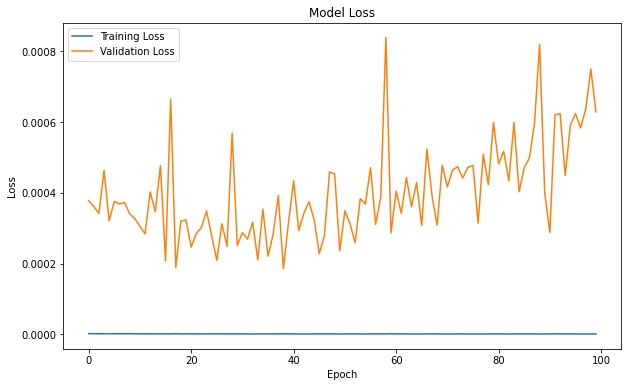

In [109]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Train the model and capture training history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [148]:
# Extract the last 10 days of historical data before the prediction date
# Replace '2023-10-07' with the date you want to predict
input_date = '2023-10-09'
input_data = df[df['Date'] <= input_date].tail(sequence_length)['Open'].values
input_data_normalized = scaler.transform(input_data.reshape(-1, 1)).reshape(1, -1, 1)

# Predict the stock price for the specified date
predicted_price_normalized = savedModel.predict(input_data_normalized)
predicted_prices = scaler.inverse_transform(predicted_price_normalized)[0][0]

print(f"Predicted Stock Price on {input_date}: {predicted_prices:.5f}")


1/1 [==============================] - 0s 57ms/step
Predicted Stock Price on 2023-10-09: 0.00020


In [112]:
import pickle

with open('LSTMmodel.pkl', 'wb') as handle:
    pickle.dump(model, handle)


INFO:tensorflow:Assets written to: ram://d5f9db39-20a9-4d3b-a1a7-8c1a9596e2bc/assets


INFO:tensorflow:Assets written to: ram://d5f9db39-20a9-4d3b-a1a7-8c1a9596e2bc/assets


In [124]:
model_directory = r'C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project'
model.save(model_directory)

INFO:tensorflow:Assets written to: C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project\assets


INFO:tensorflow:Assets written to: C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project\assets


In [138]:
import tensorflow as tf


# Load the model from the specified directory
loaded_model = tf.keras.models.load_model(model_directory)
loaded_model

In [121]:
model

In [127]:
import pickle

# Specify the file path where you want to save the DataFrame
dataframe_file_path = 'df.pkl'

# Pickle (serialize) the DataFrame and save it to the file path
with open(dataframe_file_path, 'wb') as dataframe_file:
    pickle.dump(df, dataframe_file)

In [140]:
df

,Date,Open
0,1987-10-26,0.000882
1,1987-10-27,0.000882
2,1987-10-28,0.000882
3,1987-10-29,0.000882
4,1987-10-30,0.000882
...,...,...
9016,2023-08-08,0.000066
9017,2023-08-09,0.000026
9018,2023-08-10,0.000000
9019,2023-08-11,0.000092


In [144]:
model.save('gfgModel.h5')
print('Model Saved!')
 

Model Saved!


In [146]:
# load model
savedModel=tf.keras.models.load_model('gfgModel.h5')
savedModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [137]:
df = pickle.load(open('df.pkl', 'rb'))
df

,Date,Open
0,1987-10-26,0.000882
1,1987-10-27,0.000882
2,1987-10-28,0.000882
3,1987-10-29,0.000882
4,1987-10-30,0.000882
...,...,...
9016,2023-08-08,0.000066
9017,2023-08-09,0.000026
9018,2023-08-10,0.000000
9019,2023-08-11,0.000092
